In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
%matplotlib inline

names = ['ind', 'ax', 'ay', 'az', 'label']
acc_names = ['ax', 'ay', 'az']
label2str = {1:'Working at Computer', 2:'Standing Up, Walking and Going up-down stairs', 
             3:'Standing', 4:'Walking',5:'Going Up\Down Stairs', 6:'Walking and Talking with Someone', 
             7:'Talking while Standing'}
df = pd.read_csv("Dataset/1.csv", sep=',', names=names)
del df['ind']
df = df[df.label != 0]
df['label_str'] = df.label.apply(lambda x:label2str[x])

# Magnitude
df['mag'] = np.sqrt(np.square(df[acc_names]).sum(axis=1)) 
# Median filter - 3rd ordre
def med_fil(df, names):
    df_r = pd.DataFrame()
    df = df[names]
    for column in df.columns:
        name = column+'_mf'
        df_r[name] = signal.medfilt(df[column].values)
    return df_r
df_med = med_fil(df, acc_names)
# Diffrential
def diffrential(df, names):
    df = df[names]
    df_r = df.diff(periods=1, axis=0).fillna(method='backfill')
    df_r.columns = [names[0]+'_d', names[1]+'_d', names[2]+'_d']
    return df_r
df_diff = diffrential(df, acc_names)
# Low pass filter
def lowpass(df, names):
    df = df[names]
    df_r = pd.DataFrame()
    fs = 52 # frequence sampling is 52
    f_cut = 1 # cutoff frequency
    fs_n = f_cut*2.0/fs # normalized frequency
    b,a = signal.butter(N=3, Wn=fs_n, btype='low')
    for column in df.columns : 
        name = column+'_lp'
        df_r[name] = signal.lfilter(b,a,df[column].values)
    return df_r
df_lp = lowpass(df, acc_names)  
# High pass filter 
def highpass(df, names):
    df = df[names]
    df_r = pd.DataFrame()
    fs = 52 # frequence sampling is 52
    f_cut = 1 # cutoff frequency
    fs_n = f_cut*2.0/fs # normalized frequency
    b,a = signal.butter(N=3, Wn=fs_n, btype='high')
    for column in df.columns : 
        name = column+'_hp'
        df_r[name] = signal.lfilter(b,a,df[column].values)
    return df_r
df_hp = highpass(df, acc_names)

# Total
df = pd.concat([df, df_med, df_diff, df_lp, df_hp], axis=1)
# names = ['ax','ay','az','mag','ax_mf','ay_mf','az_mf','ax_lp','ay_lp','az_lp', 'ax_hp','ay_hp','az_hp']


def extract_variables(df):
    m = df.mean(axis=0).values
    ma = df.mad(axis=0).values
    std = df.std(axis=0).values
    minimum = df.min(axis=0).values
    maximum = df.max(axis=0).values
    skew = df.skew(axis=0).values
    kurt = df.kurtosis(axis=0).values
    inteQ = (df.quantile(q=0.75, axis=0).values - df.quantile(q=0.25, axis=0).values)
    r = np.hstack([m, ma, std, minimum, maximum, skew, kurt, inteQ])    
    return r
def windowing(signal,size,step):
    d = len(signal) #length of the signal
    nk = int(np.floor((d-size+1)/step))+1 #le nombre de fenetres
    wk = np.zeros((nk,size)) #windows
    for j in range(nk):
        wk[j,:] = signal[j*step:j*step+size]
    return wk
def window_labels(labels,size,step):
    d = len(labels) #length of the signal
    nk = int(np.floor((d-size+1)/step))+1 #le nombre de fenetres
    labelwk = np.zeros((nk)) #window labels
    for j in range(nk):
        labelwk[j] = np.max(np.argmax(np.bincount(labels[j*step:j*step+size])))
    return labelwk
def extract_windows(df,size,step):
    
    """
    extract windows with the specified size and step from the dataframe df
    
    Returns:
    L : List of dataframes. Each dataframe contains a window extracted from each signal in df.
    labels: labels of windows
    """
    
    L = []
    n = df.shape[0]
    L_windows = dict()
    n_windows = int(np.floor((n-size+1)/step))+1
    for column in df.columns:
        if column not in ['label','label_str']:
            L_windows[column] = windowing(df[column],size,step)
    for i in range(n_windows):
        ddf = pd.DataFrame()
        for column in df.columns:
            if column not in ['label','label_str']:
                ddf[column] = L_windows[column][i,:]
        L.append(ddf)
    labels = window_labels(df['label'],size,step)
    return L,labels
Nbr_samples = 52
percentage = 0.5 # Between 0 & 1
df_X, df_Y = extract_windows(df,Nbr_samples,int(percentage*Nbr_samples))
X = extract_variables(df_X[0])
for i in range(1,len(df_X)):
    vec = extract_variables(df_X[i])
    X = np.vstack([X,vec])
    
y = np.array(df_Y) 

df = pd.DataFrame(X)
df['label'] = y

## LDA

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Colormap
df_lda = df.copy()
df_lda = df_lda.loc[df['label'].isin([2,3,5,6])]

In [6]:
df_LDA = df_lda.copy()
label_list = df_LDA.label.unique()

# Within-class scatter matrix
grouped = df_LDA.groupby('label')
Sw = grouped.get_group(label_list[1]).cov()
del Sw['label']
Sw = Sw.drop(['label'])
for i in label_list[1:]:
    S1 = grouped.get_group(i).cov()
    S1 = S1.drop(['label'])
    del S1['label']
    Sw = Sw + S1
    
# Between-class scatter matrix
C = len(label_list) # Number of classes
Nf = df_LDA.columns.shape[0] - 1  # Number of features
a = df_LDA.mean(axis=0)
del a['label']
u = a.values
Sb = np.zeros((Nf,Nf))
for i in label_list:
    Ni = len(df[df.label==i])
    mn = df[df.label==i].mean()
    del mn['label']    
    ui = mn.values
    x = ui-u
    x = x[:, None]
    Sb += Ni*np.dot(x,x.T)


# Projection Matrix Theta
Proj_dim=3
w,v =  np.linalg.eig(np.dot(np.linalg.inv(Sw),Sb))
Theta = np.real(v[:,0:Proj_dim])
label=df_LDA.label
del df_LDA['label']
Y = np.dot(Theta.T, df_LDA.values.T).T # Projected data

In [ ]:
plt.plot(np.log(np.abs(w)))
plt.title('The eigenvalues of Sw^-1 Sb')

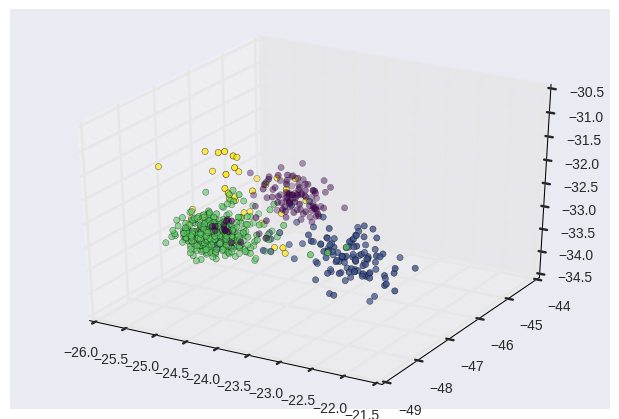

In [7]:
# Display projected data in 3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Y[:,0],Y[:,1], Y[:,2], c=label, cmap='viridis_r')

## KDA

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Colormap
from sklearn.metrics.pairwise import rbf_kernel

df_kda = df.copy()
df_kda = df_kda.loc[df['label'].isin([2,3,5,6])]

In [9]:
df_KDA = df_kda.copy()
label_list = df_KDA.label.unique()
grouped = df_KDA.groupby('label')
X = df_KDA.copy()
del X['label']
X=X.values

In [10]:
K=rbf_kernel(X,X)
[n,m]=K.shape
W_int = np.zeros((n,n))
W = np.zeros((n,n))
for i in np.arange(n):
    for j in np.arange(i+1):
        k = df_KDA.label.values[i]
        W_int[i,j] = (df_KDA.label.values[i]==df_KDA.label.values[j])*(1./len(df[df.label==k]))
W = W_int + W_int.T - np.multiply(np.eye(n), W_int)

In [11]:
# Within-class scatter matrix
Sw = np.dot(K,K)

# Between-class scatter matrix
Sb = np.dot(K,np.dot(W,K))

# Projection Matrix Theta
Proj_dim=3
w,v =  np.linalg.eig(np.dot(np.linalg.inv(Sw),Sb))
Alpha = np.real(v[:,0:Proj_dim])
label=df_KDA.label
del df_KDA['label']
Y = np.dot(Alpha.T,K).T #np.dot(Theta.T, df_LDA.values.T).T # Projected data

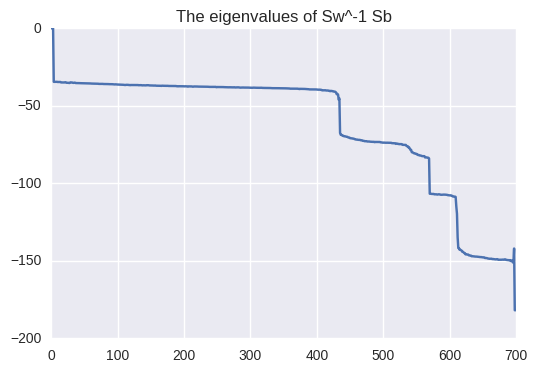

In [12]:
plt.plot(np.log(np.abs(w)))
plt.title('The eigenvalues of Sw^-1 Sb')

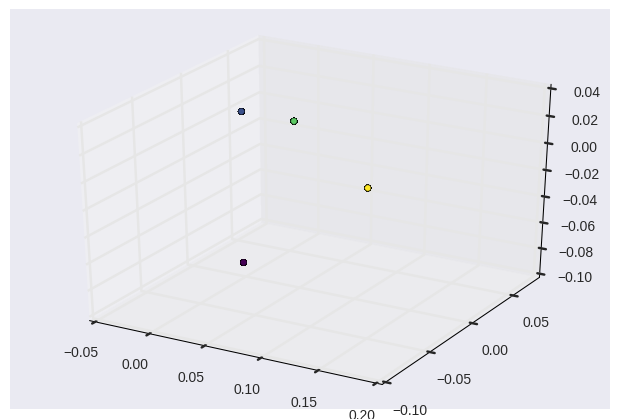

In [20]:
# Display projected data in 3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Y[:,0],Y[:,1], Y[:,2], c=label.values, cmap='viridis_r')

In [27]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
y_LR = label.values
X_LR = Y
lr = LogisticRegressionCV()
lr.fit(X_LR, y_LR)
y_pred = lr.predict(X_LR)
# cross_val_score(lr, X_LR, y_LR, cv=5)

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(label.values, y_pred)

array([[ 35,   0,   0,   0],
       [  0, 430,   0,   0],
       [  0,   0, 123,   0],
       [  0,   0,   0, 112]])

## LDA with Sklearn

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
df_kda = df.copy()
df_kda = df_kda.loc[df['label'].isin([1,3,4,5])]
lda = LinearDiscriminantAnalysis(n_components=3)
y=df_kda.label.values
del df_kda['label']
# del df_kda['label_str']
X = df_kda.values
lda.fit(X,y)
LDA = lda.fit_transform(X,y)

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(LDA[:,0],LDA[:,1], LDA[:,2], c=y, cmap='viridis_r')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
X,y = shuffle(X,y)
print(cross_val_score(lda, X, y, cv=5))